
# Deposit Decision Predictor: Model Training and Evaluation

In [ ]:
import pandas as pd
import zipfile
import urllib.request
from sklearn.preprocessing import LabelEncoder

# Parsisiųsti ZIP failą su duomenimis
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
file_name = "bank-additional.zip"
urllib.request.urlretrieve(url, file_name)
with zipfile.ZipFile(file_name, "r") as zip_ref:
    zip_ref.extractall()
data = pd.read_csv("bank-additional/bank-additional-full.csv", delimiter=";")
data.shape

(41188, 21)

Nagrinejama DB yra sudaryta is 41188 zmoniu duomenu (tarp duomenu yra ir ekonominiai globalus rodikliai), kurie yra 20 kintamuju ir 1 rezultato reiksme, t.y ar zmogus paeme terminuota indeli

<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-455-5ea496076e83>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotat

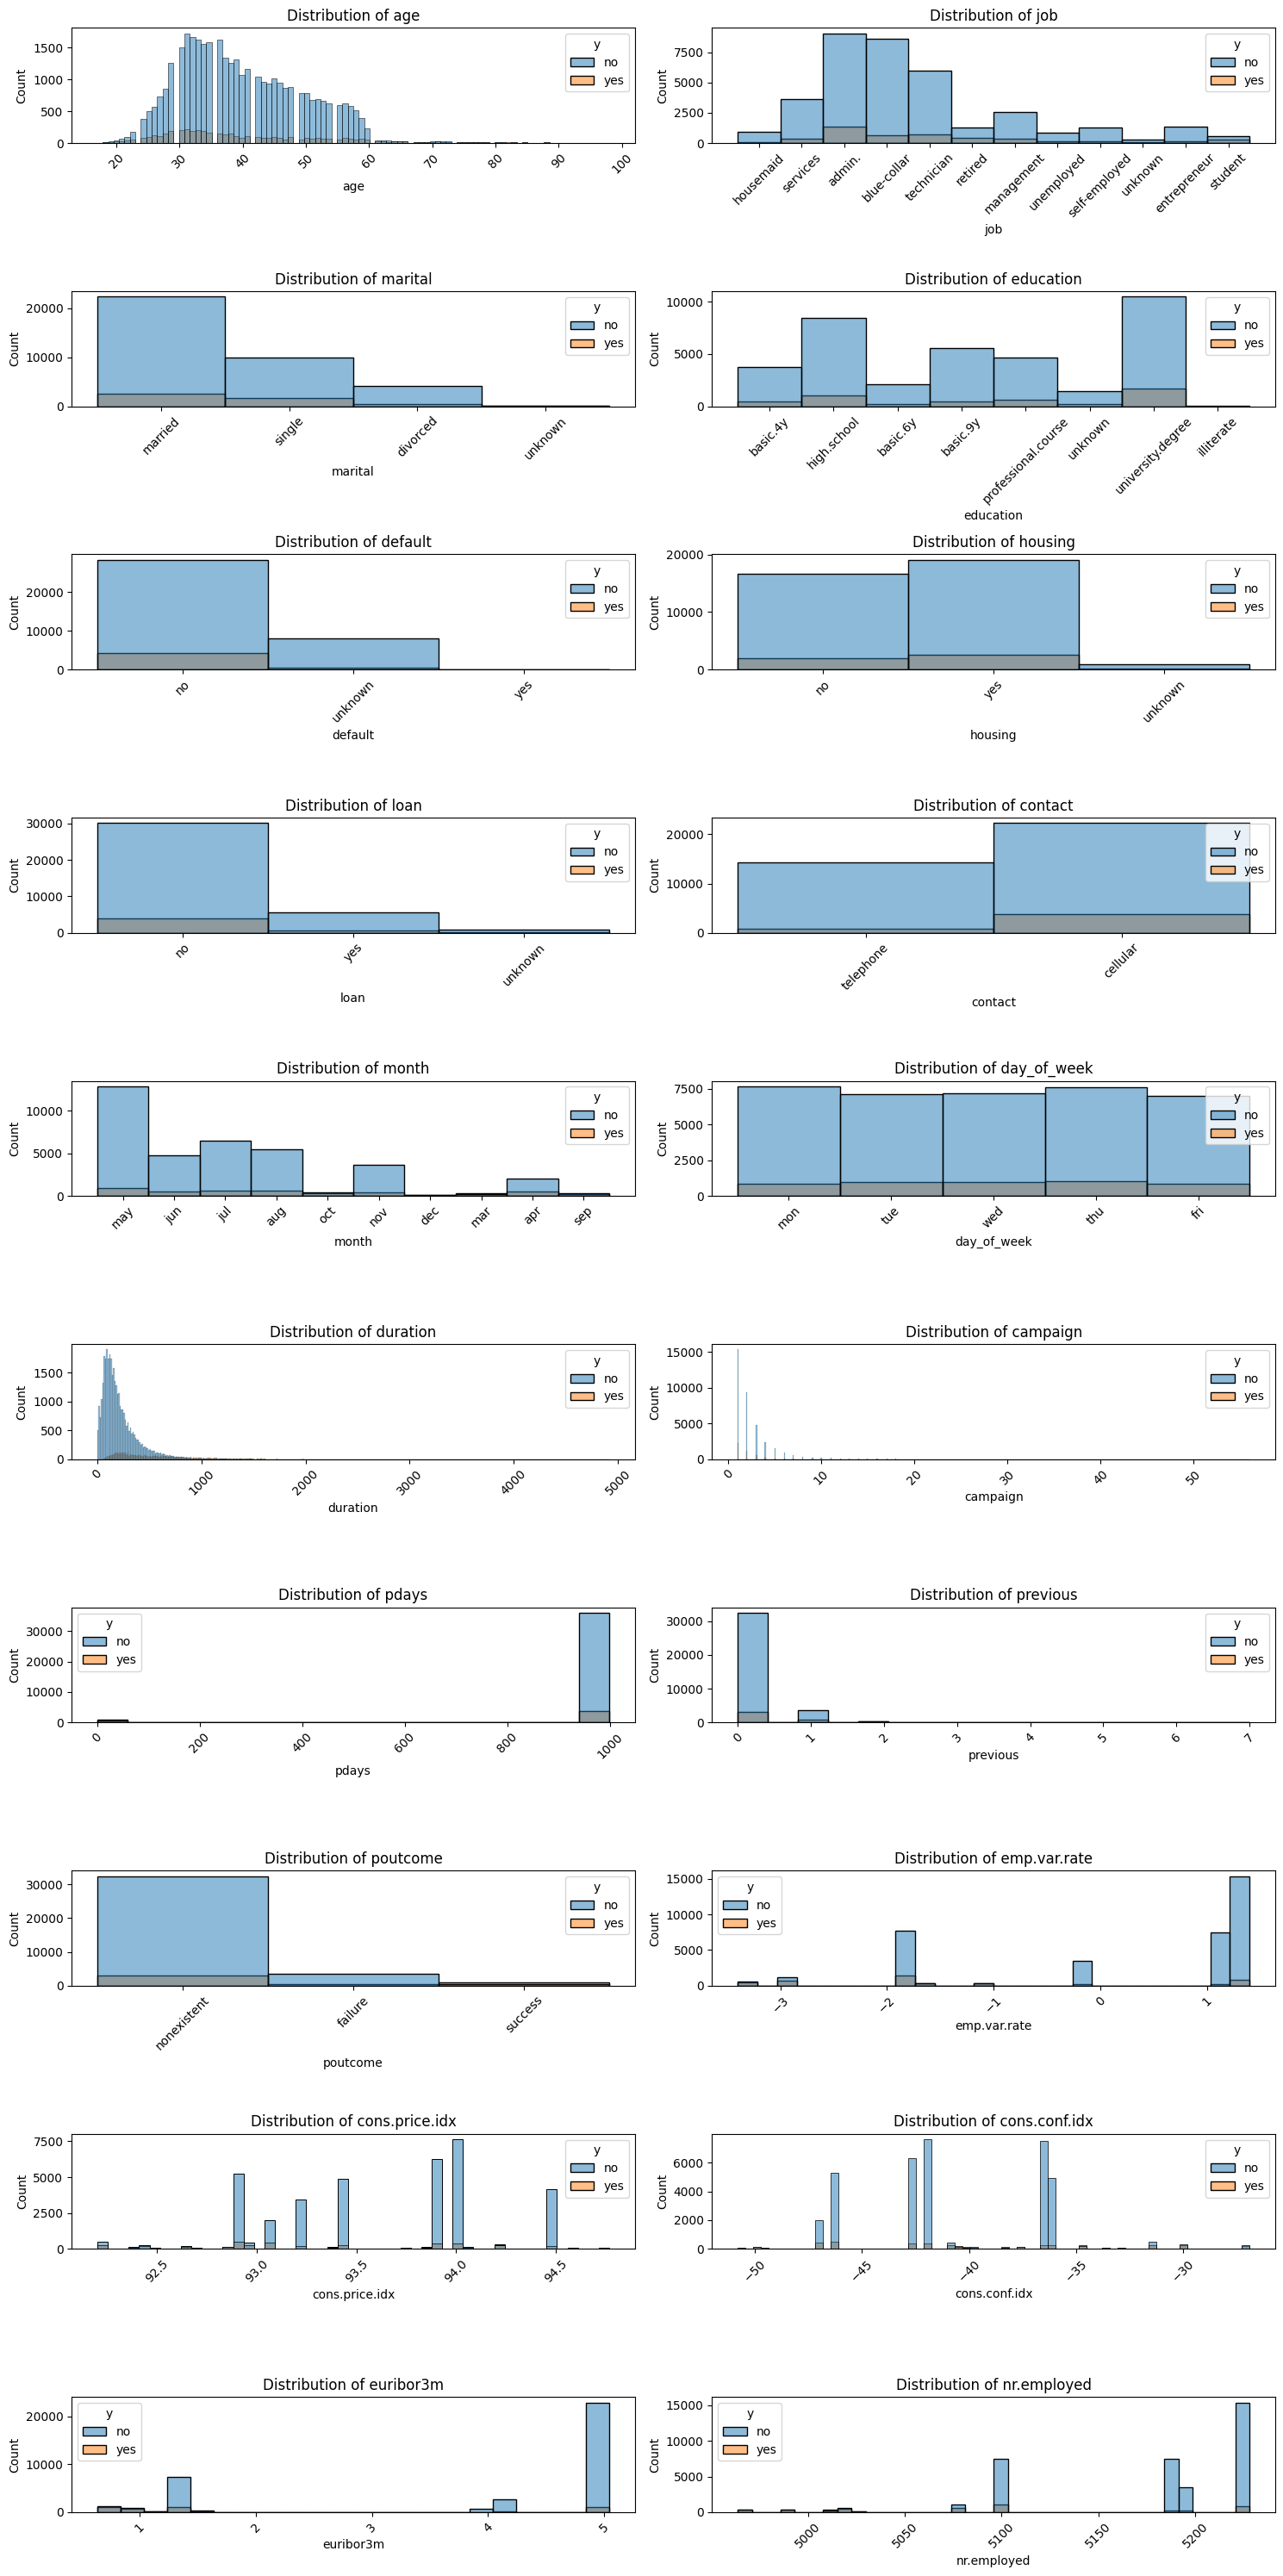

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X = data.drop('y', axis=1)
y = data['y']

data_for_plotting = pd.concat([X, y], axis=1)


cols_per_row = 2
num_features = X.shape[1]

num_rows = (num_features + cols_per_row - 1) // cols_per_row


fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 3*num_rows))
fig.subplots_adjust(hspace=0.5)


for i, feature in enumerate(X.columns):
    row_idx = i // cols_per_row
    col_idx = i % cols_per_row
    ax = axes[row_idx, col_idx]
    sns.histplot(data=data_for_plotting, x=feature, hue='y', ax=ax)
    ax.set_title(f'Distribution of {feature}')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

if num_features % cols_per_row != 0:
    for i in range(num_features, num_rows * cols_per_row):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

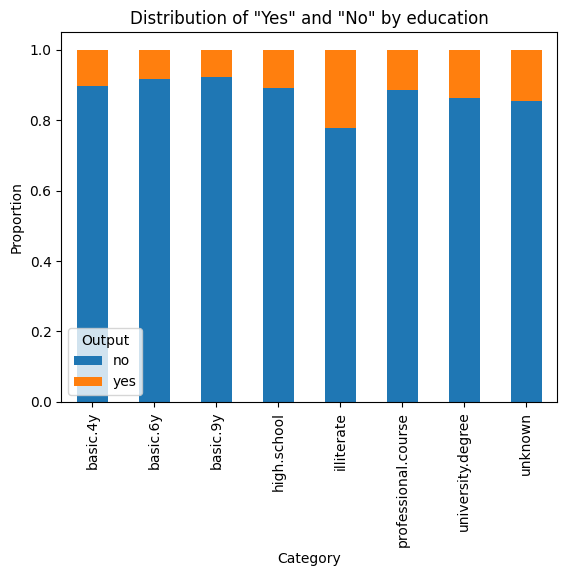

In [ ]:
category_counts = data.groupby('education')['y'].value_counts(normalize=True).unstack().fillna(0)


category_counts.plot(kind='bar', stacked=True)
plt.title('Distribution of "Yes" and "No" by education')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.legend(title='Output')
plt.show()

In [ ]:
yes_count = (data['y'] == 'yes').sum()
no_count = (data['y'] == 'no').sum()
ratio=yes_count/(no_count+yes_count)
print(ratio)

0.11265417111780131


Is siu histogramu galime matyti, kokie zmoniu bruozai, ar ekonominiai rodikliai turi itakos paimti terminuota indeli zinant, kad 11.27% zmoniu ji paeme

Realaus modelio kurimui turime apdoroti duomenis

In [ ]:
data=data.drop('duration',axis=1)

Ismetame duration stulpeli, nes bankas tada tik ir issiaiskina, ar zmogus ims terminuota indeli (tai butu vienas is svarbiausiu kintamuju, nes nuo jo stipriai priklauso y reiksme). Verciau butu zinoti duomenis apie asmeni ir ekoniminius rodiklius, kad reklama butu atitinkama.

In [ ]:

has_missing_values = data.isna().any().any()

if has_missing_values:
    print("Yra neuzpildytu reiksmiu, kuriame nors stulpelyje")
else:
    print("Visi stulpeliai uzpildyti reiksmem")

Visi stulpeliai uzpildyti reiksmem


Visgi tarp duomenu yra nezinomu reiksmiu pvz. education='unknown'

In [ ]:

sum1=(data['job']=='unknown').sum()
sum2=(data['education']=='unknown').sum()
sum6=(data['default']=='unknown').sum()

sum3=(data['loan']=='unknown').sum()
sum4=(data['poutcome']=='nonexistent').sum()
sum5=(data['housing']=='unknown').sum()
print("job_unknown",sum1)
print("education_unknown",sum2)
print("loan_unknown",sum3)
print("poutcome_unknown",sum4)
print("housing_unknown",sum5)
print("default_unknown",sum6)



job_unknown 330
education_unknown 1731
loan_unknown 990
poutcome_unknown 35563
housing_unknown 990
default_unknown 8597


Nagrinejame tik kintamuosius, kurie yra <2000. Poutcome ir default nezinomu reiksmiu nebandysime pakeist, nes zmogus daznai nesiskelbia, ar turi kreditiniu isipareigojimu problema ir daznai yra nezinoma informacija, ar praeitos kompanijos reklama buvo sekminga.

In [ ]:
initial_row_count = len(data)
df=data
df=df.drop('default',axis=1)
values_to_filter = ['unknown']
has_unknown = df.apply(lambda row: 'unknown' in row.values, axis=1)

count_with_unknown = len(df[has_unknown & (df['y'] == 'yes')])

for column in df.columns:
         df = df[~df[column].isin(values_to_filter)]

remaining_row_count = len(df)
rows_removed = initial_row_count - remaining_row_count
print("Count of 'y'='yes' when there is at least one 'unknown' row:", count_with_unknown)
print("Number of rows removed:", rows_removed)



Count of 'y'='yes' when there is at least one 'unknown' row: 382
Number of rows removed: 2943


Panaikindami eilutes su nezinomom reiksmem prarastume tikslumo ir dali duomenu apie 7%, kuriuose yra apie 13% paemusiu indeli.

In [ ]:
df = pd.DataFrame(data)
education_map = {
    'professional.course': 7,
    'university.degree': 6,
    'high.school': 5,
    'basic.9y': 4,
    'basic.6y': 3,
    'basic.4y': 2,
    'illiterate': 1,
    'unknown':0
}
loan_map={
    'yes':-1,
    'no':1,
    'unknown':0
    }
marital_map={
    'single':3,
    'divorced':2,
    'married':1,
    'unknown':0
}
housing_map={
    'yes':-1,
    'no':1,
    'unknown':0
}

job_map={
    'student': 1,
    'unemployed': 2,
    'housemaid': 3,
    'blue-collar': 4,
    'services': 5,
    'entrepreneur': 6,
    'self-employed': 7,
    'technician': 8,
    'admin.': 9,
    'unknown': 10,
    'management': 11,
    'retired': 12

}

df['education'] = df['education'].map(education_map)
df['loan'] = df['loan'].map(loan_map)
df['marital'] = df['marital'].map(marital_map)
df['housing'] = df['housing'].map(housing_map)
df['job']=df['job'].map(job_map)
data=df





Taip duomenim yra priskirtos skaitines reiksmes (galima sakyt naudotasi LabelEncoder), duomenyse pastebeta hierarchija, t.y. university.degree>high.school, admin>house.maid ir panasiai)

Galima uzpildyti unknown reiksmes (siuo atveju yra jos pazymetos skaiciais) keliais budais: darant logiskas prielaidas (jeigu age>=65, tai job=retired arba, jei job=student -> education=high.school) arba sukuriant modelius likusiom nezinomom reiksmes uzpildyti.

In [ ]:
condition1 = (df['job'] == 1) & (df['education'] == 0)
df.loc[condition1, 'education'] = 5
condition2 = (df['age'] > 64 ) & (df['job'] == 10)
df.loc[condition2,'job']=12



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score



df = pd.DataFrame(data)


features = ['marital', 'age', 'job', 'loan', 'housing']
target = 'education'

unknown_rows = df[df[target] == 0]
changed_indices = df[df['education'] == 0].index

X_train = df[df[target] != 0][features]
y_train = df[df[target] != 0][target]
X_test = unknown_rows[features]

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

predicted_values = rf_classifier.predict(X_test)

df.loc[df[target] == 0, target] = predicted_values

#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy}")
print("Updated DataFrame:")

changed_rows_df = df.loc[changed_indices]

changed_rows_df=df.iloc[1]
print("DataFrame with changed rows:")
print(changed_rows_df)

Updated DataFrame:
DataFrame with changed rows:
age                        57
job                         5
marital                     1
education                   5
default               unknown
housing                     1
loan                        1
contact             telephone
month                     may
day_of_week               mon
campaign                    1
pdays                     999
previous                    0
poutcome          nonexistent
emp.var.rate              1.1
cons.price.idx         93.994
cons.conf.idx           -36.4
euribor3m               4.857
nr.employed            5191.0
y                          no
Name: 1, dtype: object


Tai 57, vedes, be namo paskolos ir kredito problemu, paslaugu sektoriuje dirbantis asmuo turi  pagrindini issilavinima.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
df = pd.DataFrame(data)
features = ['marital', 'age', 'education', 'loan', 'housing']
target = 'job'

unknown_rows = df[df[target] == 10]
changed_indices = df[df['job'] == 10].index

X_train = df[df[target] != 10][features]
y_train = df[df[target] != 10][target]
X_test = unknown_rows[features]

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

predicted_values = rf_classifier.predict(X_test)

df.loc[df[target] == 10, target] = predicted_values


#print(f"Accuracy: {accuracy}")
print("Updated DataFrame:")

changed_rows_df = df.loc[changed_indices]

print("DataFrame with changed rows:")
print(changed_rows_df)
data=df

Updated DataFrame:
DataFrame with changed rows:
       age  job  marital  education  default  housing  loan    contact month  \
29      55    9        1          6  unknown        0     0  telephone   may   
35      55    4        1          2  unknown       -1     1  telephone   may   
73      57   12        1          0  unknown        1     1  telephone   may   
91      57    4        1          0  unknown       -1     1  telephone   may   
144     38    9        2          5  unknown       -1     1  telephone   may   
...    ...  ...      ...        ...      ...      ...   ...        ...   ...   
40244   42    9        3          6       no       -1     1   cellular   jul   
40370   59   12        1          0       no        1     1   cellular   aug   
40428   64   12        1          0       no       -1     1  telephone   aug   
41005   63   12        1          7       no        1     1   cellular   oct   
41108   64   12        1          0       no        1     1   cellular  

Kitus duomenis category tipo duomenis uzpildome paprastai, one hot encoding ir label encoding budais.


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df=data
data = pd.get_dummies(data, columns=['month'], prefix=['month'])
data = pd.get_dummies(data, columns=['day_of_week'], prefix=['day_of_week'])

data['default'] = label_encoder.fit_transform(data['default'])
data['contact'] = label_encoder.fit_transform(data['contact'])
data['poutcome'] = label_encoder.fit_transform(data['poutcome'])
data['y'] = label_encoder.fit_transform(data['y'])



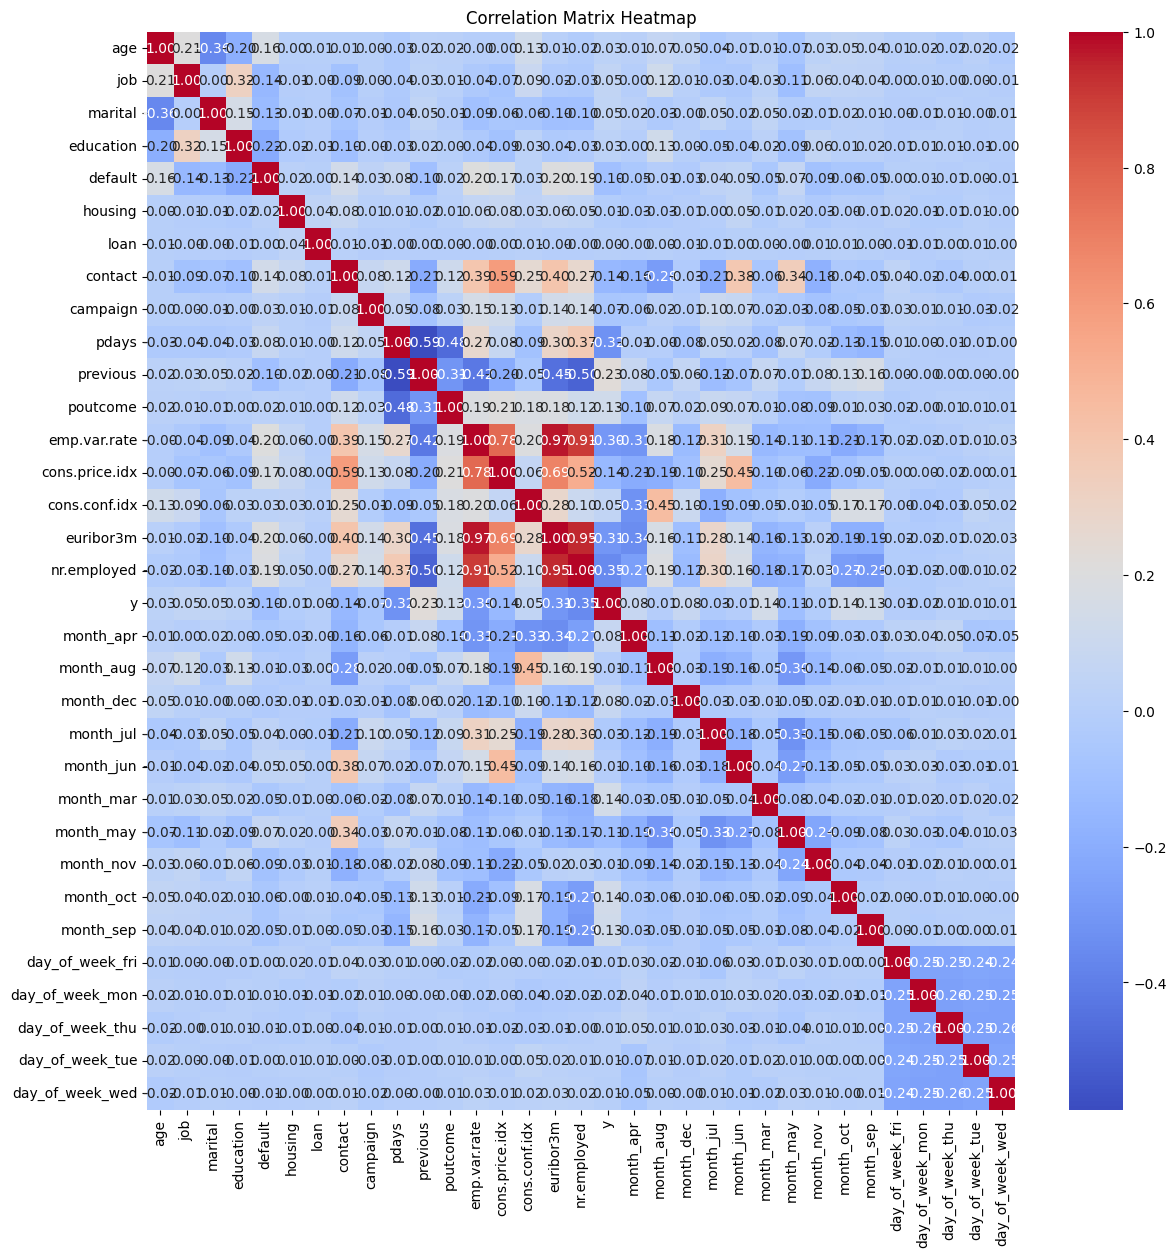

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = data.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
Is koorelaciju matricos matome, kad labiausiai paimti indeliui, turi ekonominiai rodikliai.
Sudarome tris modelius: logistine regresijos, Decision tree ir random forest.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score



X = data.drop('y', axis=1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = LogisticRegression(max_iter=1000000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Recall: 0.22
Precision: 0.64
Accuracy: 0.90
Confusion Matrix:
[[3598   59]
 [ 359  103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3657
           1       0.64      0.22      0.33       462

    accuracy                           0.90      4119
   macro avg       0.77      0.60      0.64      4119
weighted avg       0.88      0.90      0.88      4119



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

X = df.drop('y',axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.88
Recall: 0.52
Precision: 0.49
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7303
           1       0.49      0.52      0.50       935

    accuracy                           0.88      8238
   macro avg       0.71      0.72      0.72      8238
weighted avg       0.89      0.88      0.88      8238



In [ ]:

X = data.drop('y', axis=1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

pd.DataFrame(rf.feature_importances_,
             index=data.drop('y', axis=1).columns).style.background_gradient()

Accuracy: 0.90
Confusion Matrix:
[[7185  118]
 [ 742  193]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.62      0.21      0.31       935

    accuracy                           0.90      8238
   macro avg       0.76      0.60      0.63      8238
weighted avg       0.87      0.90      0.87      8238

Precision: 0.49
Recall: 0.52


,0
age,0.185037
job,0.092239
marital,0.038124
education,0.076386
default,0.015001
housing,0.037380
loan,0.026524
contact,0.015809
campaign,0.087385
pdays,0.040845


Taigi visi modeliai gana tiksliai apraso duomenis ir gauna aukstas accuracy>90. Taciau duomenys nera balansuoti ir tokiu atveju nors ir yra aukstas accuracy, bet gali buti, kad priskiria teisingai mazai reiksmiu. Tai galima pamatyti is confusion matricos. Recall and precision yra identiski decision tree ir random forest modeliuose, o logistines regresijos atveju precision yra labai zemas, nes daug duomenu buvo blogai uzfiksuoti. Taigi geriau butu pasirinkti random forest, nes aukstesnis accuracy. Galima nagrineti ir kitus paklaidu ir tikslumo nustatymo budus.